In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold

import time

In [3]:
num_classifiers = 5
best_accuracy = np.zeros(num_classifiers)
train_time = np.zeros(num_classifiers)
test_time = np.zeros(num_classifiers)

wine_df = pd.read_csv("data/winequalityN.csv")
wine_df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [4]:
cleanup_wines = {"type":     {"white": 0, "red": 1}
                }
wine_df.replace(cleanup_wines,inplace = True)
wine_df = wine_df.dropna()

In [5]:
target = wine_df['quality']
target[target < 6] = 0
target[target >= 6] = 1
wine_df.drop( ['quality'],axis = 1,inplace = True)

/anaconda3/envs/mlclass/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
X_train,X_test,Y_train,Y_test = train_test_split(wine_df, target, random_state=42)

In [7]:
print(len(X_train))
print(len(Y_train))
print(len(X_test))
print(len(Y_test))

4847
4847
1616
1616


In [8]:
target.value_counts()

1    4091
0    2372
Name: quality, dtype: int64

In [9]:
sc=StandardScaler()
sc.fit(X_train)
X_train_std=sc.transform(X_train)
X_test_std=sc.transform(X_test)

In [10]:
from sklearn import tree
dt_stump = tree.DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)
clf_boosted = AdaBoostClassifier(base_estimator=dt_stump, random_state=42)
clf_boosted.fit(X_train, Y_train)
clf_boosted.score(X_train, Y_train)


0.7699608004951516

In [11]:
f_pred = clf_boosted.predict(X_test)
print('Misclassified samples using Boost are: %d' %(Y_test!=f_pred).sum())
print('Classification Accuracy of Boost is %.2f ' %accuracy_score(Y_test,f_pred))

Misclassified samples using Boost are: 413
Classification Accuracy of Boost is 0.74 


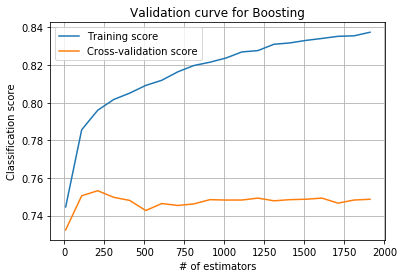

In [12]:
estimator_range = np.arange(10,2000,100)
dt_stump = tree.DecisionTreeClassifier(max_depth=1, min_samples_leaf=1, random_state=42)
clf_boosted = AdaBoostClassifier(base_estimator=dt_stump, n_estimators=1500, random_state=42)
train_scores, test_scores = validation_curve(clf_boosted, X_train, Y_train, param_name="n_estimators", param_range=estimator_range, cv=5,
                                            n_jobs=4)

plt.figure()
plt.plot(estimator_range, np.mean(train_scores, axis=1), label='Training score')
plt.plot(estimator_range, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Validation curve for Boosting')
plt.xlabel('# of estimators')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
plt.show()

In [13]:
estimator_range = np.arange(100,300,5)
tuned_params = {'n_estimators' : estimator_range}
clf_boosted = GridSearchCV(clf_boosted, param_grid=tuned_params, cv=5, n_jobs=4)
t0 = time.time()
clf_boosted.fit(X_train, Y_train)
t1 = time.time()
train_time[0] = t1 - t0
print('Completed training in %f seconds' % train_time[0])
best_clf_boosted = clf_boosted
best_boosted_params = clf_boosted.best_params_
print("Best parameters set for decision tree found on development set:")
print(best_boosted_params)
t0 = time.time()
boosted_pred_best = clf_boosted.predict(X_test)
t1 = time.time()
test_time[0] = t1 - t0
print('Inference time on test data: %f seconds' % test_time[0])
best_accuracy[0] = accuracy_score(Y_test, boosted_pred_best)
print('Accuracy of decision tree is %.2f%%' % (best_accuracy[0] * 100))
from sklearn.metrics import confusion_matrix
print(confusion_matrix(Y_test, boosted_pred_best))

Completed training in 43.428142 seconds
Best parameters set for decision tree found on development set:
{'n_estimators': 215}
Inference time on test data: 0.052980 seconds
Accuracy of decision tree is 75.99%
[[374 230]
 [158 854]]


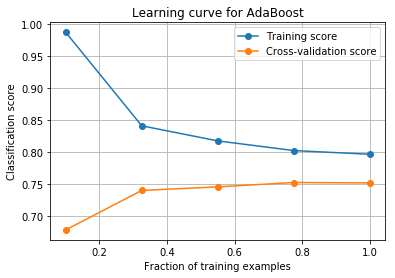

In [14]:
train_sizes = np.linspace(0.1, 1.0, 5)
best_clf_boosted = AdaBoostClassifier(base_estimator=dt_stump, n_estimators=best_boosted_params['n_estimators'], random_state=42)
_, train_scores, test_scores = learning_curve(best_clf_boosted, X_train, Y_train, train_sizes=train_sizes, cv=5, n_jobs=4)

plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Cross-validation score')
plt.title('Learning curve for AdaBoost')
plt.xlabel('Fraction of training examples')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_learning_curve.png')
plt.show()